In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import axes3d    

# Constants
k_B = 1.38e-23  # Boltzmann constant (J/K)
T = 20e-6  # Temperature in Kelvin
m = 1.443e-25  # Mass of Rubidium-87 atom in kg
mu_B = 9.274e-24  # Bohr magneton in J/T
g_f = 1/2  # Landé g-factor for simplicity
dt = 1e-5  # Time step for simulation in seconds
num_steps = 1000 # Number of time steps

# Read magnetic field data
data = pd.read_csv('magnet-Iu=40-Ibias=-0.60-A.txt', delim_whitespace=True)
BB = np.zeros([100, 100, 100])
B = data["mfco.normB1"]
for j in range(100):
    for k in range(100):
        for z in range(100):
            BB[z, k, j] = B[z + k * 100 + j * 10000]

# Get the dimensions of the field grid
field_height, field_width, field_long = BB.shape
x = np.linspace(-4.95, 4.95, field_height) * 1e-3
y = np.linspace(-4.95, 4.95, field_width) * 1e-3
z = np.linspace(6.02, 9.66, field_long) * 1e-3

# Interpolator for the magnetic field magnitude
B_interpolator = RegularGridInterpolator((x, y, z), BB, bounds_error=False, fill_value=None)

# Number of atoms to simulate
num_atoms = 5000

# Function to generate random velocities with Maxwell-Boltzmann distribution
def generate_random_velocities(num_atoms, temperature, mass):
    speeds = np.random.normal(0, np.sqrt(k_B * temperature / mass), num_atoms)
    phi = np.random.uniform(0, 2 * np.pi, num_atoms)
    costheta = np.random.uniform(-1, 1, num_atoms)
    sintheta = np.sqrt(1 - costheta**2)
    directions = np.vstack((sintheta * np.cos(phi), sintheta * np.sin(phi), costheta)).T
    velocities = speeds[:, np.newaxis] * directions
    return velocities

# Initialize positions of atoms using Gaussian distribution
center = np.array([0.0, 0.0, 7.02e-3])  # Center of the Gaussian distribution
positions_initial = np.random.normal(center, 5e-4, (num_atoms, 3))  # 1e-3 is the standard deviation

# Define the initial ellipsoidal region to count atoms in (center and radii)
region_radii = np.array([1e-3, 1e-3, 1e-3])

# Generate initial velocities with random directions
velocities_initial = generate_random_velocities(num_atoms, T, m)

# Assign random m_f values to each atom
m_f = np.random.choice([-4,-3,-2,-1, 0, 1,2,3,4], num_atoms)

# Function to compute the force on each atom due to the magnetic field gradient
def compute_force(positions):
    epsilon = 1e-9  # Small step for numerical gradient
    
    # Compute numerical gradient of U
    grad_U = np.zeros_like(positions)
    for dim in range(3):
        pos_plus = np.copy(positions)
        pos_minus = np.copy(positions)
        pos_plus[:, dim] += epsilon
        pos_minus[:, dim] -= epsilon
        U_plus = g_f * m_f * mu_B * B_interpolator(pos_plus)
        U_minus = g_f * m_f * mu_B * B_interpolator(pos_minus)
        grad_U[:, dim] = (U_plus - U_minus) / (2 * epsilon)
    
    force = -grad_U
    return force

# Runge-Kutta 4th order method for updating positions and velocities
def rk4_step(positions, velocities, dt):
    def derivatives(pos, vel):
        force = compute_force(pos)
        return vel, force / m
    
    k1_vel, k1_acc = derivatives(positions, velocities)
    k2_vel, k2_acc = derivatives(positions + 0.5 * dt * k1_vel, velocities + 0.5 * dt * k1_acc)
    k3_vel, k3_acc = derivatives(positions + 0.5 * dt * k2_vel, velocities + 0.5 * dt * k2_acc)
    k4_vel, k4_acc = derivatives(positions + dt * k3_vel, velocities + dt * k3_acc)
    
    new_positions = positions + (dt / 6.0) * (k1_vel + 2*k2_vel + 2*k3_vel + k4_vel)
    new_velocities = velocities + (dt / 6.0) * (k1_acc + 2*k2_acc + 2*k3_acc + k4_acc)
    
    return new_positions, new_velocities

def count_atoms_in_region(positions, center, radii):
    distances = np.linalg.norm((positions - center) / radii, axis=1)
    atoms_in_region = np.sum(distances <= 1)
    return atoms_in_region

# Function to run the simulation
def run_simulation(positions, velocities, with_field=True):
    positions_over_time = []
    atoms_in_region_over_time = []

    for step in range(num_steps):
        positions_over_time.append(np.copy(positions))
        if with_field:
            positions, velocities = rk4_step(positions, velocities, dt)
        else:
            positions += dt * velocities 

        atoms_in_region = count_atoms_in_region(positions, center, region_radii)
        atoms_in_region_over_time.append(atoms_in_region)

    return np.array(positions_over_time), atoms_in_region_over_time

# Run the simulations
positions_with_field, atoms_in_region_with_field = run_simulation(
    np.copy(positions_initial), np.copy(velocities_initial), with_field=True)
positions_free_expansion, atoms_in_region_free_expansion = run_simulation(
    np.copy(positions_initial), np.copy(velocities_initial), with_field=False)

# Separate positions by m_f state for plotting
positions_mf1_with_field = positions_with_field[-1][m_f == 1]
positions_mf0_with_field = positions_with_field[-1][m_f == 0]
positions_mf_neg1_with_field = positions_with_field[-1][m_f == -1]

positions_mf1_free_expansion = positions_free_expansion[-1][m_f == 1]
positions_mf0_free_expansion = positions_free_expansion[-1][m_f == 0]
positions_mf_neg1_free_expansion = positions_free_expansion[-1][m_f == -1]

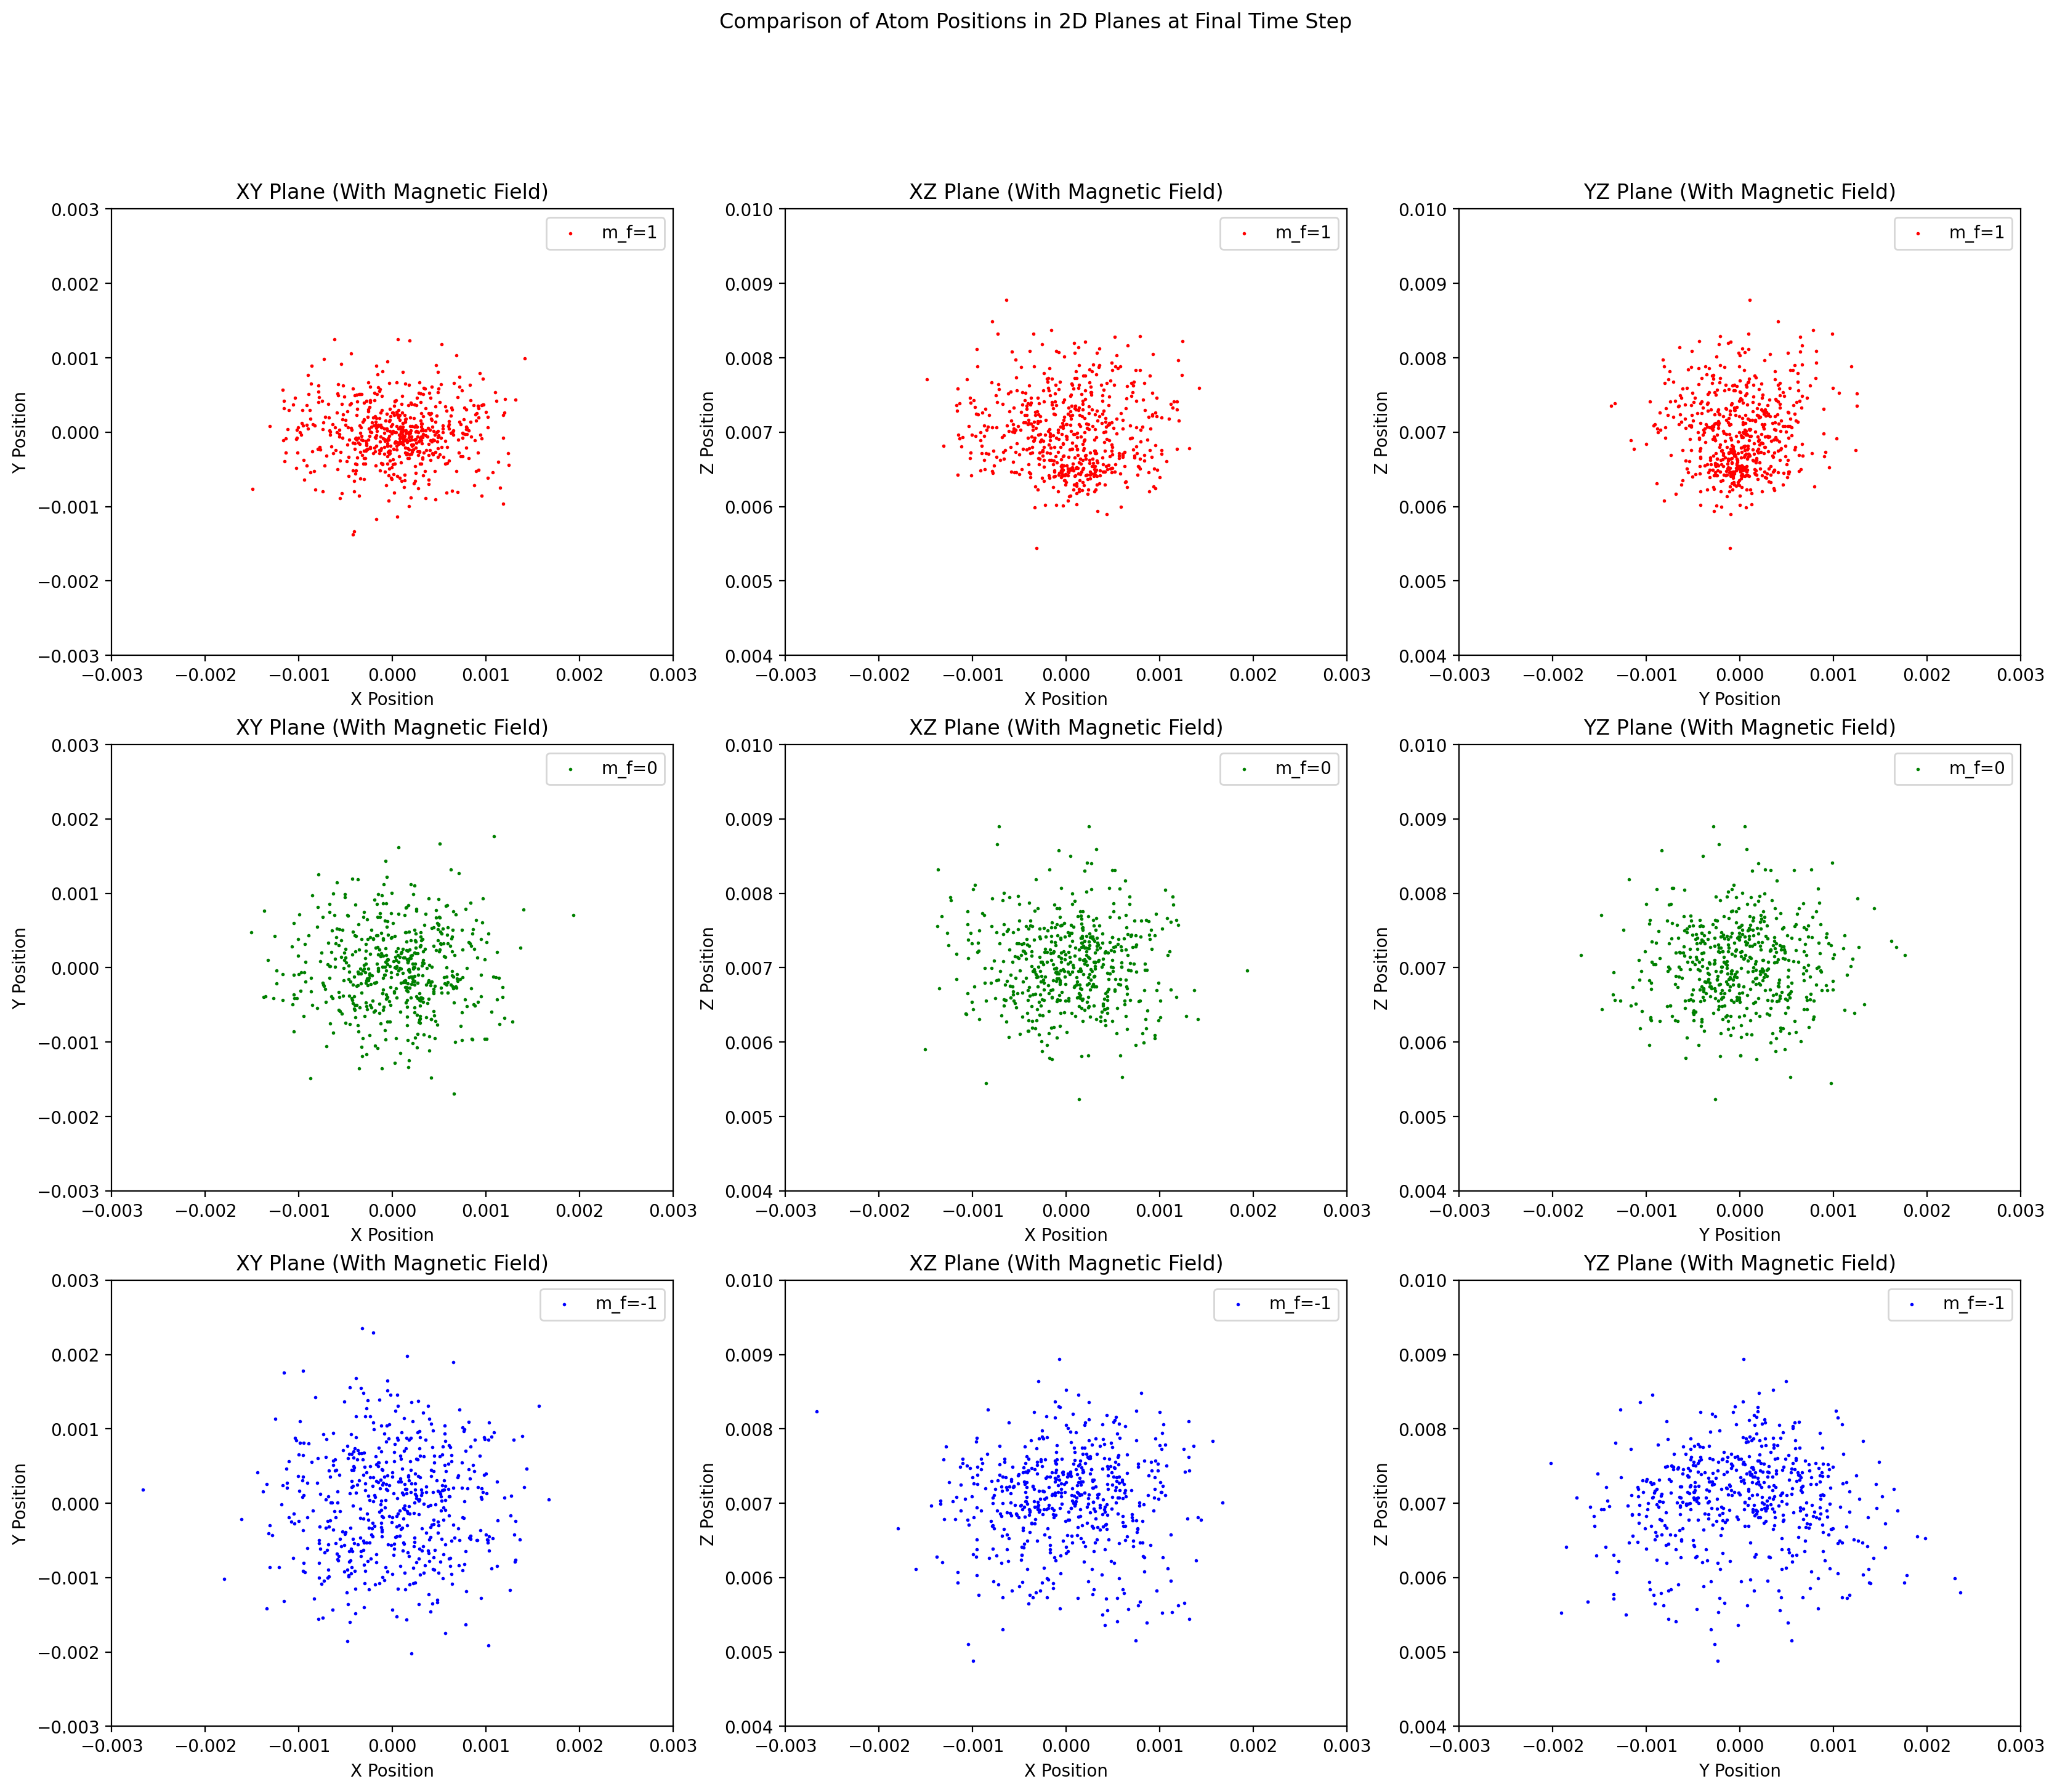

In [26]:
# Plotting the atom positions over time in 2D scatter plots for final time step
fig, axes = plt.subplots(3, 3, figsize=(20, 16), dpi=200)

# XY Plane
axes[0, 0].scatter(positions_mf1_with_field[:, 0], positions_mf1_with_field[:, 1], s=1, c='r', label='m_f=1')
axes[0, 0].set_xlabel('X Position')
axes[0, 0].set_ylabel('Y Position')
axes[0, 0].set_xlim(-3e-3, 3e-3)
axes[0, 0].set_ylim(-3e-3, 3e-3)
axes[0, 0].set_title('XY Plane (With Magnetic Field)')
axes[0, 0].legend()

axes[1, 0].scatter(positions_mf0_with_field[:, 0], positions_mf0_with_field[:, 1], s=1, c='g', label='m_f=0')
axes[1, 0].set_xlabel('X Position')
axes[1, 0].set_ylabel('Y Position')
axes[1, 0].set_xlim(-3e-3, 3e-3)
axes[1, 0].set_ylim(-3e-3, 3e-3)
axes[1, 0].set_title('XY Plane (With Magnetic Field)')
axes[1, 0].legend()

axes[2, 0].scatter(positions_mf_neg1_with_field[:, 0], positions_mf_neg1_with_field[:, 1], s=1, c='b', label='m_f=-1')
axes[2, 0].set_xlabel('X Position')
axes[2, 0].set_ylabel('Y Position')
axes[2, 0].set_xlim(-3e-3, 3e-3)
axes[2, 0].set_ylim(-3e-3, 3e-3)
axes[2, 0].set_title('XY Plane (With Magnetic Field)')
axes[2, 0].legend()

# XZ Plane
axes[0, 1].scatter(positions_mf1_with_field[:, 0], positions_mf1_with_field[:, 2], s=1, c='r', label='m_f=1')
axes[0, 1].set_xlabel('X Position')
axes[0, 1].set_ylabel('Z Position')
axes[0, 1].set_xlim(-3e-3, 3e-3)
axes[0, 1].set_ylim(4e-3, 10e-3)
axes[0, 1].set_title('XZ Plane (With Magnetic Field)')
axes[0, 1].legend()

axes[1, 1].scatter(positions_mf0_with_field[:, 0], positions_mf0_with_field[:, 2], s=1, c='g', label='m_f=0')
axes[1, 1].set_xlabel('X Position')
axes[1, 1].set_ylabel('Z Position')
axes[1, 1].set_xlim(-3e-3, 3e-3)
axes[1, 1].set_ylim(4e-3, 10e-3)
axes[1, 1].set_title('XZ Plane (With Magnetic Field)')
axes[1, 1].legend()

axes[2, 1].scatter(positions_mf_neg1_with_field[:, 0], positions_mf_neg1_with_field[:, 2], s=1, c='b', label='m_f=-1')
axes[2, 1].set_xlabel('X Position')
axes[2, 1].set_ylabel('Z Position')
axes[2, 1].set_xlim(-3e-3, 3e-3)
axes[2, 1].set_ylim(4e-3, 10e-3)
axes[2, 1].set_title('XZ Plane (With Magnetic Field)')
axes[2, 1].legend()

# YZ Plane
axes[0, 2].scatter(positions_mf1_with_field[:, 1], positions_mf1_with_field[:, 2], s=1, c='r', label='m_f=1')
axes[0, 2].set_xlabel('Y Position')
axes[0, 2].set_ylabel('Z Position')
axes[0, 2].set_xlim(-3e-3, 3e-3)
axes[0, 2].set_ylim(4e-3, 10e-3)
axes[0, 2].set_title('YZ Plane (With Magnetic Field)')
axes[0, 2].legend()

axes[1, 2].scatter(positions_mf0_with_field[:, 1], positions_mf0_with_field[:, 2], s=1, c='g', label='m_f=0')
axes[1, 2].set_xlabel('Y Position')
axes[1, 2].set_ylabel('Z Position')
axes[1, 2].set_xlim(-3e-3, 3e-3)
axes[1, 2].set_ylim(4e-3, 10e-3)
axes[1, 2].set_title('YZ Plane (With Magnetic Field)')
axes[1, 2].legend()

axes[2, 2].scatter(positions_mf_neg1_with_field[:, 1], positions_mf_neg1_with_field[:, 2], s=1, c='b', label='m_f=-1')
axes[2, 2].set_xlabel('Y Position')
axes[2, 2].set_ylabel('Z Position')
axes[2, 2].set_xlim(-3e-3, 3e-3)
axes[2, 2].set_ylim(4e-3, 10e-3)
axes[2, 2].set_title('YZ Plane (With Magnetic Field)')
axes[2, 2].legend()

plt.suptitle('Comparison of Atom Positions in 2D Planes at Final Time Step')
plt.show()

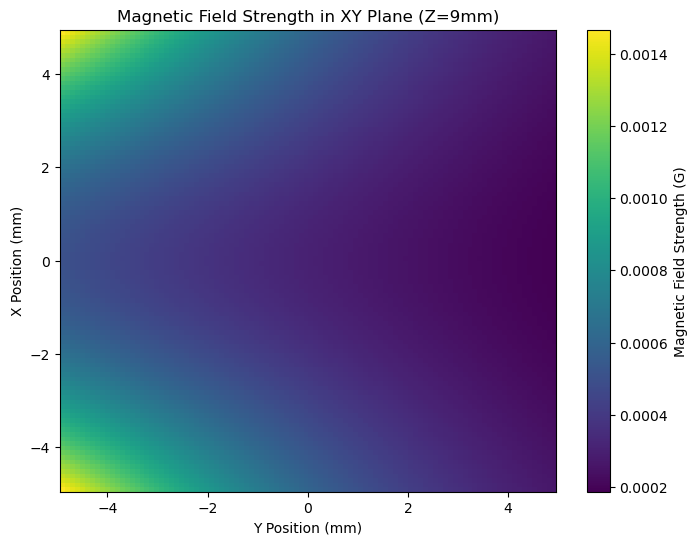

In [53]:
# 2D Color Plot for XY-plane
xy_plane_index = 99  # Slice at the middle of Z-axis (XY plane)
B_xy_plane = BB[xy_plane_index, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(B_xy_plane, extent=[y.min()*1e3, y.max()*1e3, x.min()*1e3, x.max()*1e3], origin='lower', aspect='auto')
plt.colorbar(label='Magnetic Field Strength (G)')
plt.title('Magnetic Field Strength in XY Plane (Z=9mm)')
plt.xlabel('Y Position (mm)')
plt.ylabel('X Position (mm)')
plt.show()